### Initialize Database Connection and Load the Data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

# Load the data
df_smartthings = db.get_smartthings()
df_weather = db.get_weather_data()

### Prepare the Data 

In [12]:
# Convert epoch time to datetime in df_smartthings and df_weather
df_smartthings['datetime'] = pd.to_datetime(df_smartthings['epoch'], unit='s')
df_weather['datetime'] = pd.to_datetime(df_weather['time'], unit='s')

# Extract weekends from the datetime
df_smartthings['is_weekend'] = df_smartthings['datetime'].dt.weekday >= 5
df_weather['is_weekend'] = df_weather['datetime'].dt.weekday >= 5

# Filter data to focus on motion detection events
motion_df = df_smartthings[df_smartthings['capability'] == 'motionSensor']

# Merge the two datasets on the nearest datetime to align weather data with motion events
merged_df = pd.merge_asof(
    motion_df.sort_values('datetime'),
    df_weather.sort_values('datetime'),
    on='datetime',
    direction='nearest'
)

# Filter merged data to only include weekends
weekend_df = merged_df[merged_df['is_weekend_x']]


### Calculate Descriptives 

In [13]:
# Calculate descriptive statistics for key weather variables on weekends
weather_stats = weekend_df[['temperature_2m', 'relativehumidity_2m', 'rain']].describe()

# Calculate the number of motion events per weekend day
weekend_df['date'] = weekend_df['datetime'].dt.date
motion_counts = weekend_df.groupby('date').size().reset_index(name='motion_count')

# Merge the motion counts back with the weather data for the corresponding dates
motion_weather_df = pd.merge(motion_counts, weekend_df[['date', 'temperature_2m', 'rain']].drop_duplicates(), on='date')

# Display descriptive statistics
print(weather_stats)

       temperature_2m  relativehumidity_2m           rain
count   108265.000000        108265.000000  108265.000000
mean        10.170972            80.642969       0.123841
std          5.805288            11.491245       0.412726
min         -5.300000            34.000000       0.000000
25%          6.800000            74.000000       0.000000
50%          9.400000            83.000000       0.000000
75%         13.800000            90.000000       0.000000
max         31.100000           100.000000       7.000000


/var/folders/1t/r1rc54fd3s9_qs3h2wbr2xvh0000gn/T/ipykernel_76550/769235812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df['date'] = weekend_df['datetime'].dt.date


### Make Scatterplot and Fit Regression Line 

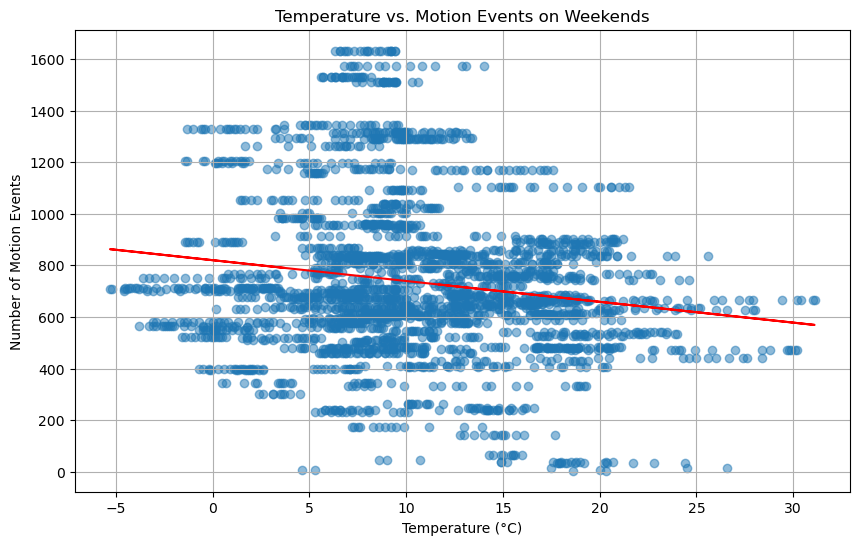

In [14]:
# Scatter plot for temperature vs. motion events
plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], alpha=0.5)
plt.title('Temperature vs. Motion Events on Weekends')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Motion Events')

# fitting a linear regression line
m, b = np.polyfit(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], 1)

# adding the regression line to the scatter plot
plt.plot(motion_weather_df['temperature_2m'], m*motion_weather_df['temperature_2m'] + b, color='red')
plt.grid(True)
plt.show()

### Perform Regression Analysis

In [15]:
# Perform regression analysis
slope, intercept, r_value, p_value, std_err = linregress(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'])

# Display regression results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

Slope: -8.068062724234185
Intercept: 820.0879241893285
R-squared: 0.02760987602760584
P-value: 6.399478081280609e-19
Standard Error: 0.9016391338234236
